# Prédiction des durées

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from xgboost import XGBRegressor

In [4]:
data_path = "data/clean_data.parquet"
df = pd.read_parquet(data_path)

In [5]:
df.head()

,No Cas,date_entree,date_sortie,date_naissance,sexe,cim_diag_pr,Cim Assoc 1,Cim Assoc 2,Cim Assoc 3,Cim Assoc 4,...,heure_incision,heure_sortie_salle,anesth_type,anesth_loco_reg,duree_sejour,interv_type,duree_sspi,duree_op,age,urgence
0,1678286,2019-01-04,2019-01-04,1961-09-20,2,140,F17.25,F41.8,R00.2,None,...,0 days 14:29:00,0 days 15:10:00,5,13,1,1009,0 days 00:51:00,0 days 00:57:00,20925 days,False
1,1676952,2019-01-03,2019-01-03,1966-02-15,1,475,F17.25,F10.26,I10,None,...,0 days 00:00:00,0 days 08:45:00,5,10,1,810,0 days 00:30:00,0 days 00:45:00,19315 days,True
2,1661837,2019-01-03,2019-01-03,1964-08-14,2,140,M20.4,R00.1,None,None,...,0 days 08:29:00,0 days 09:40:00,-1,13,1,1011,0 days 00:39:00,0 days 01:32:00,19865 days,False
3,1680505,2019-01-04,2019-01-04,2004-10-29,2,362,None,None,None,None,...,0 days 09:07:00,0 days 09:31:00,4,17,1,810,0 days 00:37:00,0 days 00:49:00,5180 days,False
4,1681248,2019-01-04,2019-01-04,2006-06-12,1,61,None,None,None,None,...,0 days 12:29:00,0 days 12:36:00,0,1,1,1348,0 days 00:34:00,0 days 00:16:00,4589 days,False


## CIM vs. Durée opération

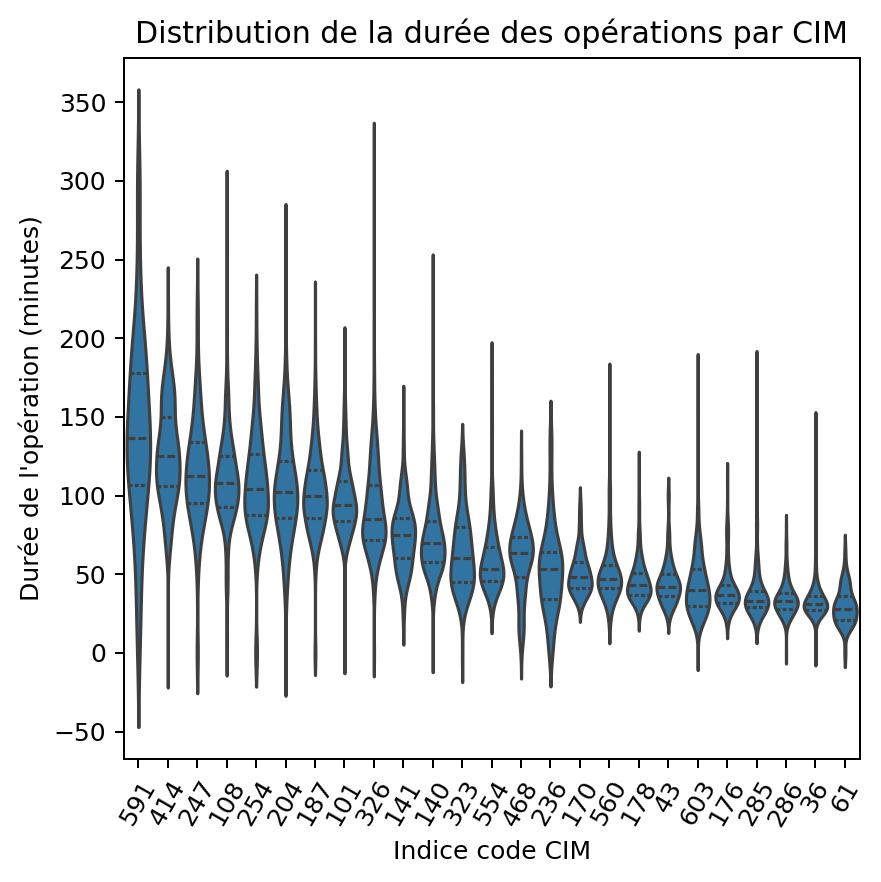

In [6]:
# Obtenir les 10 CIM les plus fréquents
top_cim_diag_pr = df['cim_diag_pr'].value_counts().head(25).index.tolist()
# Isoler les durées d'opération
df_ = df[df['cim_diag_pr'].isin(top_cim_diag_pr)][[
    'cim_diag_pr', 'duree_op'
]]

# Obtenir les moyennes de durée d'opération par CIM
duree_op_moyenne = df_.groupby('cim_diag_pr').mean().reset_index()
duree_op_moyenne = duree_op_moyenne.sort_values(by='duree_op', ascending=False)
# Trier les CIM par ordre de durée d'opération moyenne
order = duree_op_moyenne['cim_diag_pr'].tolist()

plt.figure(figsize=(5, 5), dpi=180)
sns.violinplot(
    x=df_['cim_diag_pr'],
    y=df_['duree_op'].dt.total_seconds() / 60,
    density_norm='width',
    inner='quartile',
    order=order
)

plt.xticks(rotation=60)
plt.xlabel('Indice code CIM')
plt.ylabel('Durée de l\'opération (minutes)')
plt.title('Distribution de la durée des opérations par CIM')
plt.tight_layout()

## Age vs. durée séjour

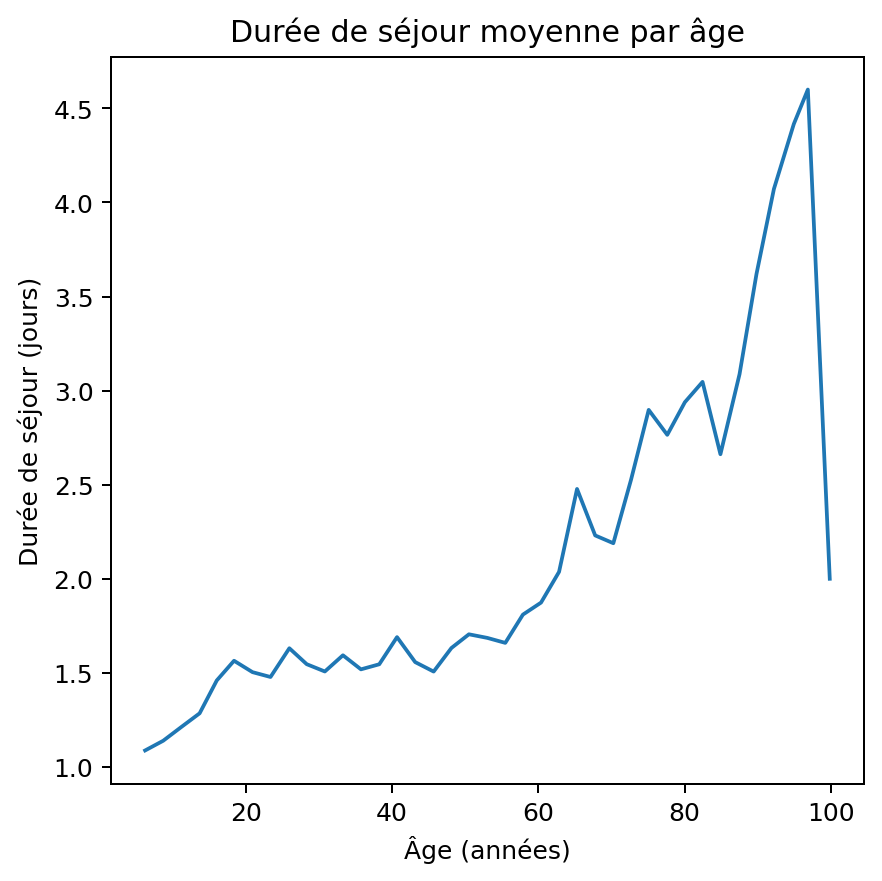

In [7]:
period = pd.to_timedelta(900, unit='D')
df_ = df[['age', 'duree_sejour']].groupby(df['age'] // period).mean()


plt.figure(figsize=(5, 5), dpi=180)
plt.plot(
    df_['age'].dt.total_seconds() / (365 * 24 * 60 * 60),
    df_['duree_sejour']
)

plt.xlabel('Âge (années)')
plt.ylabel('Durée de séjour (jours)')
plt.title('Durée de séjour moyenne par âge')
plt.tight_layout()

# Modélisation

## Données d'entrée

In [76]:
X = pd.DataFrame({
    'sexe': df['sexe'],
    'age': df['age'].dt.total_seconds() / (60 * 60 * 24 * 365),
    'cim_diag_pr': df['cim_diag_pr'],
    'ccam_1': df['ccam_1'],
    'ghm_code': df['ghm_code'],
    'anesth_type': df['anesth_type'],
    'anesth_loco_reg': df['anesth_loco_reg'],
    'interv_type': df['interv_type'],
})
y = pd.DataFrame({
    # 'duree_sspi': df['duree_sspi'].dt.total_seconds() / 60,
    'duree_op': df['duree_op'].dt.total_seconds() / 60,
    # 'duree_sejour': df['duree_sejour'],
})

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [78]:
input_shape = (X.shape[1],)

## Random Forest

In [61]:
rf = RandomForestRegressor(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

rf.fit(X_train, y_train['duree_sejour'])

RandomForestRegressor()

In [63]:
y_pred_rf = rf.predict(X_test)
print('MSE: {:.2f}'.format(mean_squared_error(y_test['duree_sejour'], y_pred_rf)))

MSE: 1.51


## XGBoost

In [74]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train['duree_op'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
y_pred_xgb = xgb.predict(X_test)
print('MSE: {:.2f}'.format(mean_squared_error(y_test['duree_op'], y_pred_xgb)))

MSE: 711.80


In [ ]:
# Figure 4: Comparaison des MSE des modèles en fonction du sorties

## Neural network

In [79]:
model = Sequential([
    BatchNormalization(input_shape=input_shape),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),

    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),

    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='relu')
])
model.compile(
    optimizer=Adam(),
    loss='mse',
    metrics=['mse']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_30 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 256)               2304      
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_31 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dropout_31 (Dropout)        (None, 128)              

In [80]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/50


241/241 [==============================] - 4s 4ms/step - loss: 7016.8550 - mse: 7012.7686 - val_loss: 4844.9663 - val_mse: 4840.6621
Epoch 2/50
241/241 [==============================] - 1s 3ms/step - loss: 3357.2642 - mse: 3352.6182 - val_loss: 1612.0891 - val_mse: 1607.1897
Epoch 3/50
241/241 [==============================] - 1s 5ms/step - loss: 2374.6804 - mse: 2369.6980 - val_loss: 1625.8800 - val_mse: 1620.8265
Epoch 4/50
241/241 [==============================] - 1s 3ms/step - loss: 2138.6841 - mse: 2133.5564 - val_loss: 1393.1405 - val_mse: 1387.9554
Epoch 5/50
241/241 [==============================] - 1s 3ms/step - loss: 2044.2700 - mse: 2039.0162 - val_loss: 1268.3330 - val_mse: 1263.0314
Epoch 6/50
241/241 [==============================] - 1s 3ms/step - loss: 1928.2715 - mse: 1922.9333 - val_loss: 1211.1809 - val_mse: 1205.8026
Epoch 7/50
241/241 [==============================] - 1s 4ms/step - loss: 1883.8109 - mse: 1878.4023 - val_loss: 1171.3119 - val_mse: 1165.8690
Epo

Text(0.5, 1.0, 'Loss en fonction des epochs pour le modèle Neural Network')

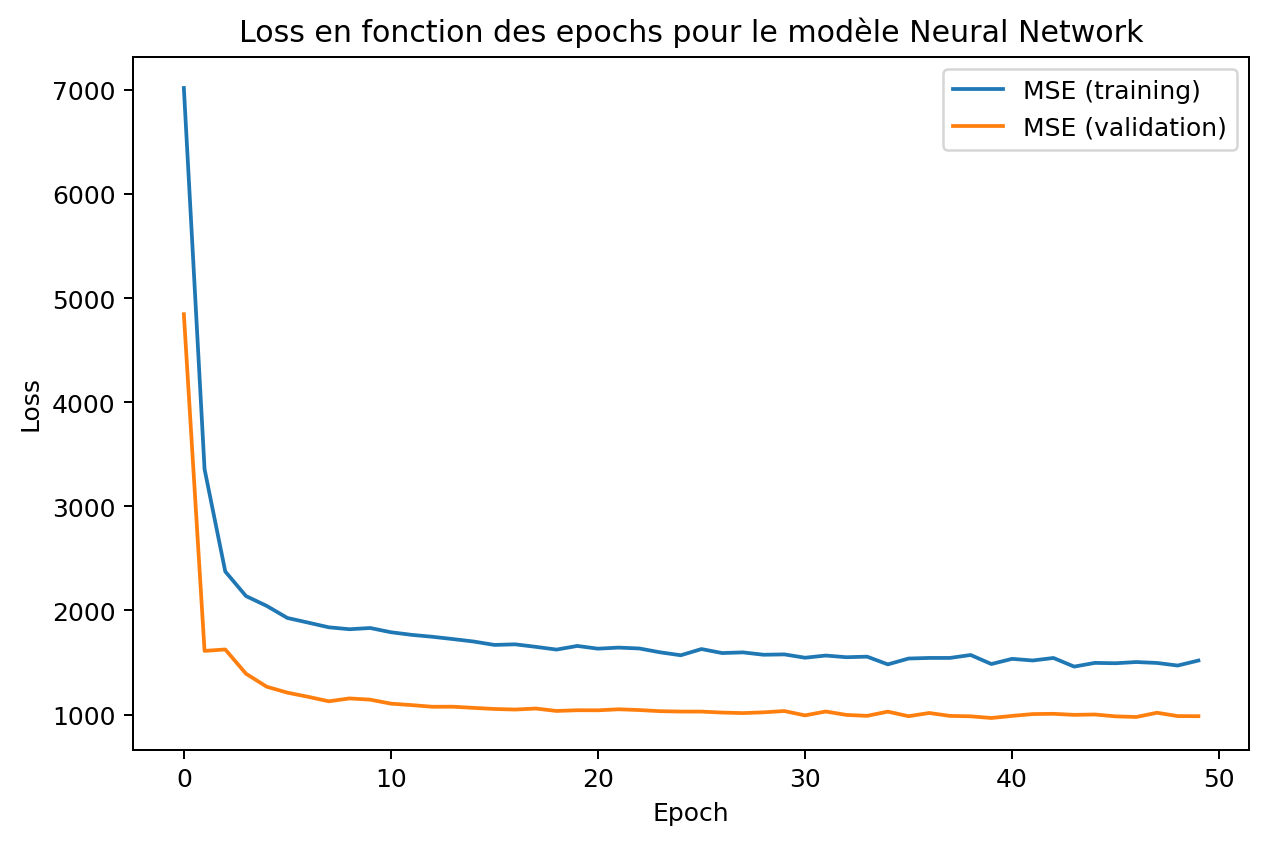

In [84]:
plt.figure(figsize=(8, 5), dpi=180)
plt.plot(history.history['loss'], label='MSE (training)')
plt.plot(history.history['val_loss'], label='MSE (validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss en fonction des epochs pour le modèle Neural Network')

In [45]:
y_pred_nn = model.predict(X_test)
print('MSE: {:.2f}'.format(mean_squared_error(y_test, y_pred_nn)))

101/101 [==============================] - 0s 1ms/step


MSE: 5018.95
